# Collaborative Filtering using Tensorflow & Keras
In our [Recommender Course](https://www.codingforentrepreneurs.com/courses/recommender/) we build a Django-based recommendation engine leveraging the Surprise ML package (among other things). This guide is made to help you upgrade your ML package by leveraging Keras and a neural network. 


Recommended requirements for running this notebook:
- GPU-accelerated / CUDA-enabled environment
- Cloud-based service such as Google Colab, Deepnote, and/or Paperspace
- [Recommender]((https://github.com/codingforentrepreneurs/recommender)) code forked/cloned/downloaded, open-source datasets loaded in, and Recommender models exported
- To export the [Recommender](https://github.com/codingforentrepreneurs/recommender)'s datasets, you can run the functions `export_rating_dataset_task` and `export_movies_dataset_task` in the `exports/tasks.py`
-  After you run these functions, you'll have the movies dataset located in `local-cdn/media/exports/movies/latest.csv` and the ratings dataset in `local-cdn/media/exports/ratings/latest.csv`



This code was directly inspired and modified from the following posts:
- [Fast.ai's Collaborative Filtering Lesson](https://course.fast.ai/Lessons/lesson7.html)
- [How to create a Recommendation System from scratch using Keras from the Antonai Blog](https://antonai.blog/how-to-create-a-recommendation-system-from-scratch-using-keras/)
- [Collaborative Filtering for Movie Recommendations the Keras Docs](https://keras.io/examples/structured_data/collaborative_filtering_movielens/)


### Open this notebook in...

[<img src="https://deepnote.com/buttons/launch-in-deepnote-white-small.svg">](https://deepnote.com/launch?url=https://github.com/codingforentrepreneurs/recommender/blob/main/src/nbs/Example%20Collaborative%20Filtering%20with%20Tensorflow%20Keras.ipynb)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/codingforentrepreneurs/recommender/blob/main/src/nbs/Example%20Collaborative%20Filtering%20with%20Tensorflow%20Keras.ipynb)

[![Run on Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/codingforentrepreneurs/recommender/blob/main/src/nbs/Example%20Collaborative%20Filtering%20with%20Tensorflow%20Keras.ipynb)

In [2]:
# !pip install tensorflow sklearn matplotlib pandas

  Using cached sklearn-0.0.post11.tar.gz (3.6 kB)


ERROR: Could not find a version that satisfies the requirement tensorflow-intel==2.13.1; platform_system == "Windows" (from tensorflow) (from versions: 0.0.1, 2.10.0.dev20220728, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0)
ERROR: No matching distribution found for tensorflow-intel==2.13.1; platform_system == "Windows" (from tensorflow)


In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# if using a cloud provider, upload your files to an "exports folder"
# exports_dir = pathlib.Path().resolve() / 'exports' 

# if running this notebook from the root of the Recommender project
exports_dir = pathlib.Path().resolve().parent /'data' / 'local-cdn' / 'media' / 'exports'

movies_exports = exports_dir / 'movies' / 'latest.csv'
ratings_exports = exports_dir / 'ratings' / 'latest.csv'
print(movies_exports.exists(), ratings_exports.exists())

True True


Load in the movies dataset

In [3]:
movies_df = pd.read_csv(movies_exports)

# add a "trend" column to combine the count of ratings with the movie's average rating
movies_df['trend'] = movies_df['rating_count'] * movies_df['rating_avg']
movies_df['movieIdx'] = movies_df['movieIdx'].astype(int)
movies_df['movieId'] = movies_df['movieId'].astype(int)

print(movies_df.shape)
movies_df.head()

(42277, 6)


,release_date,rating_count,rating_avg,movieId,movieIdx,trend
0,1995-10-30,247.0,3.97,1,0,980.59
1,1986-10-16,59.0,3.24,3,1,191.16
2,1995-12-22,13.0,2.46,4,2,31.98
3,1995-12-09,56.0,3.36,5,3,188.16
4,1995-12-15,53.0,3.34,7,4,177.02


Load in the entire ratings dataset

In [4]:
rating_df = pd.read_csv(ratings_exports)
print(rating_df.shape)
rating_df.head()

(80913, 3)


,userId,movieId,rating
0,1,300665,4
1,1,439502,4
2,1,271404,5
3,671,4896,5
4,671,4963,5


Join the movies dataset and ratings dataset.

In [5]:
df = rating_df.copy()
df['userId'] = df['userId'].astype(int)
df['movieId'] = df['movieId'].astype(int)
df = df.join(movies_df, on='movieId', rsuffix='_movie_df')
df.sort_values(by=['trend'], inplace=True, ascending=False)
print(df.shape)
df.head()

(80913, 9)


,userId,movieId,rating,release_date,rating_count,rating_avg,movieId_movie_df,movieIdx,trend
13824,564,183,5,2000-02-09,311.0,4.57,318.0,183.0,1421.27
13832,564,206,5,1994-07-06,341.0,4.15,356.0,206.0,1415.15
17617,547,206,1,1994-07-06,341.0,4.15,356.0,206.0,1415.15
18388,536,206,4,1994-07-06,341.0,4.15,356.0,206.0,1415.15
31361,451,206,4,1994-07-06,341.0,4.15,356.0,206.0,1415.15


Make note of the missing number of movies from the ratings dataset. These are missing for a couple reasons: 
- Initial dataset used had invalid ids (from the movielens datasset) - Most likely
- Movies have been deleted from the Recommender database - Likely
- Incorrect datatypes - Unlikely but possible

In [6]:
missing_data = df[df['movieIdx'].isna()]

number_of_missing_movies = len(missing_data.movieId.unique().tolist())
print(number_of_missing_movies, 'movie ids missing that were rated')

2733 movie ids missing that were rated


Drop `NaN` columns that lack a `movieIdx` value:

In [7]:
training_df = df.copy().dropna()
training_df['movieIdx'] = training_df['movieIdx'].astype(int)
training_df.shape

(53219, 9)

In [11]:
user_ids = training_df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}



movie_ids = training_df["movieIdx"].unique().tolist()

df = training_df.copy()
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieIdx"]

num_users = len(user2user_encoded)
num_movies = len(movie_ids)
total_movies = max(movie_ids)

df["rating"] = training_df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 671, Number of Movies: 3324, Min rating: 1.0, Max rating: 5.0


In [9]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [12]:
from tensorflow.keras.layers import Embedding, multiply, concatenate, Flatten, Input, Dense
from tensorflow.keras import optimizers as opt

# from sklearn.model_selection import train_test_split
# from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model



EMBEDDING_SIZE = 500
num_unique_users = num_users
num_unique_movies = total_movies
users_input = Input(shape=(1,), name="users_input")
users_embedding = Embedding(num_unique_users + 1, EMBEDDING_SIZE, name="users_embeddings")(users_input)
users_bias = Embedding(num_unique_users + 1, 1, name="users_bias")(users_input)

movies_input = Input(shape=(1,), name="movies_input")
movies_embedding = Embedding(num_unique_movies + 1, EMBEDDING_SIZE, name="movies_embedding")(movies_input)
movies_bias = Embedding(num_unique_movies + 1, 1, name="movies_bias")(movies_input)

dot_product_users_movies = multiply([users_embedding, movies_embedding])
input_terms = dot_product_users_movies + users_bias + movies_bias
input_terms = Flatten(name="fl_inputs")(input_terms)
# output = Dense(1, activation="relu", name="output")(input_terms) 

output = Dense(1, activation="sigmoid", name="output")(input_terms) 
output = output * (max_rating - min_rating) + min_rating


model = Model(inputs=[users_input, movies_input], outputs=output)

opt_adam = opt.Adam(learning_rate = 0.005)
model.compile(optimizer=opt_adam, loss= ['mse'], metrics=['mean_absolute_error'])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 users_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 movies_input (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 users_embeddings (Embeddin  (None, 1, 500)               336000    ['users_input[0][0]']         
 g)                                                                                               
                                                                                                  
 movies_embedding (Embeddin  (None, 1, 500)               2100400   ['movies_input[0][0]']    

In [14]:
df_train, df_val = train_test_split(df, random_state=42, test_size=0.2, stratify=df.rating)

In [15]:
history = model.fit(
    x=[df_train.user.to_numpy(), df_train.movie.to_numpy()],
    y=df_train.rating.to_numpy(),
    batch_size=200,
    epochs=10,
    verbose=1,
    validation_data=([df_val.user.to_numpy(), df_val.movie.to_numpy()],df_val.rating.to_numpy()))

Epoch 1/10
213/213 [==============================] - 75s 337ms/step - loss: 0.9411 - mean_absolute_error: 0.7670 - val_loss: 0.8313 - val_mean_absolute_error: 0.7104
Epoch 2/10
213/213 [==============================] - 66s 312ms/step - loss: 0.5520 - mean_absolute_error: 0.5774 - val_loss: 0.8428 - val_mean_absolute_error: 0.7148
Epoch 3/10
213/213 [==============================] - 88s 411ms/step - loss: 0.1751 - mean_absolute_error: 0.3323 - val_loss: 0.8398 - val_mean_absolute_error: 0.7163
Epoch 4/10
213/213 [==============================] - 85s 401ms/step - loss: 0.0896 - mean_absolute_error: 0.2344 - val_loss: 0.8422 - val_mean_absolute_error: 0.7119
Epoch 5/10
213/213 [==============================] - 83s 390ms/step - loss: 0.0647 - mean_absolute_error: 0.1943 - val_loss: 0.8447 - val_mean_absolute_error: 0.7143
Epoch 6/10
213/213 [==============================] - 84s 396ms/step - loss: 0.0594 - mean_absolute_error: 0.1826 - val_loss: 0.8506 - val_mean_absolute_error: 0.712

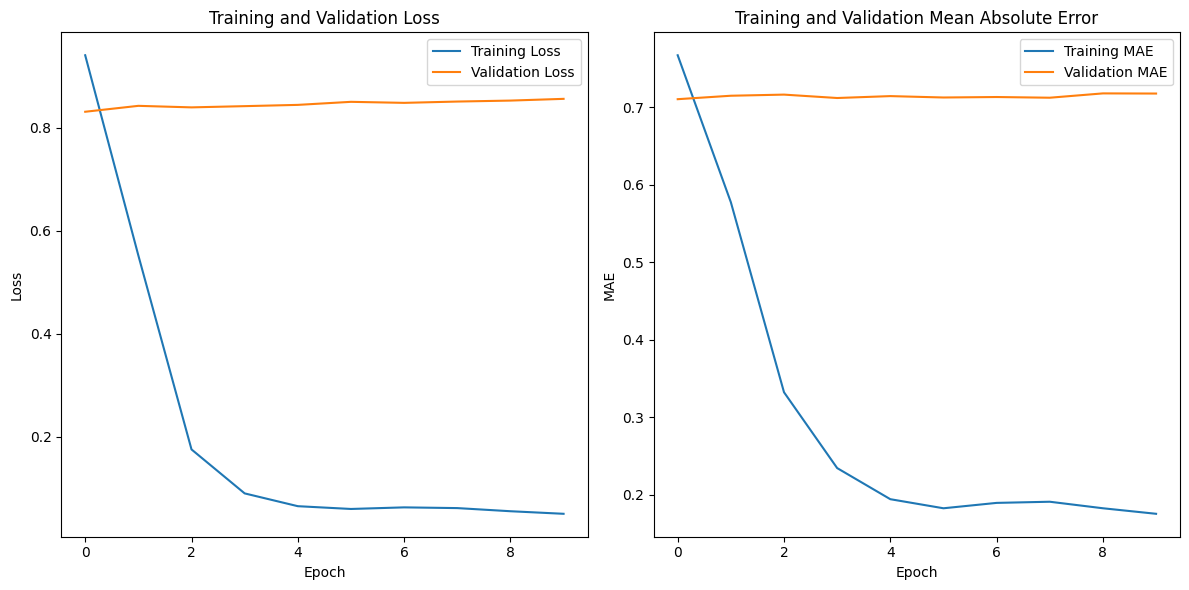

In [17]:
import matplotlib.pyplot as plt


# Lấy thông tin về quá trình đào tạo từ lịch sử
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_mae = history.history['mean_absolute_error']
validation_mae = history.history['val_mean_absolute_error']

# Vẽ đồ thị loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Vẽ đồ thị mean absolute error
plt.subplot(1, 2, 2)
plt.plot(training_mae, label='Training MAE')
plt.plot(validation_mae, label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

Save the model for reuse

In [18]:
model.save('neural_collaborative_filtering.h5')

Load model

In [19]:
from tensorflow.keras.models import load_model

loaded_model = load_model("neural_collaborative_filtering.h5")

In [20]:
number_of_preds = 100
movies = df.sample(n=number_of_preds).movie.to_list()
user_list = df.sample(n=1).user.to_list() * number_of_preds
use_id = False
if use_id:
    user_list = [user2user_encoded.get(1)] * number_of_preds
preds = loaded_model.predict(x=[np.array(user_list), np.array(movies)])
preds

4/4 [==============================] - 7s 8ms/step


array([[4.1971083],
       [2.2709575],
       [3.8541286],
       [2.99397  ],
       [3.2842648],
       [4.767696 ],
       [2.9000697],
       [4.2459974],
       [3.2318368],
       [2.1886694],
       [4.4211974],
       [2.2977142],
       [3.1902683],
       [3.9870877],
       [2.688809 ],
       [3.9437492],
       [4.7886815],
       [3.5100868],
       [4.0467253],
       [2.7755995],
       [3.0570555],
       [4.065075 ],
       [3.6254497],
       [4.7247996],
       [1.8622802],
       [4.0141535],
       [3.6408095],
       [2.7907197],
       [3.0454261],
       [3.9216452],
       [2.983789 ],
       [2.8378928],
       [2.1617084],
       [4.1293154],
       [2.6288924],
       [3.7957647],
       [3.3545172],
       [2.6533194],
       [3.247441 ],
       [2.8724394],
       [3.9058173],
       [2.9794817],
       [2.02249  ],
       [3.9896622],
       [2.9828777],
       [4.3411064],
       [3.0503092],
       [3.091005 ],
       [2.4224546],
       [3.875989 ],


In [21]:
suggestions = []
user_id = userencoded2user.get(user_list[0])

suggestions_df = movies_df.copy()[movies_df['movieIdx'].isin(movies)]
suggestions_df['userId'] = user_id

suggestions_df['score'] = suggestions_df['movieIdx'].apply(lambda x: preds[movies.index(x)][0])

for i, movieIdx in enumerate(movies):
    pred_rank = preds[i][0]
    print(user_id, movieIdx, pred_rank)

452 3911 4.1971083
452 4700 2.2709575
452 1408 3.8541286
452 2970 2.99397
452 2803 3.2842648
452 1097 4.767696
452 2420 2.9000697
452 2762 4.2459974
452 1527 3.2318368
452 3247 2.1886694
452 905 4.4211974
452 1769 2.2977142
452 1061 3.1902683
452 1 3.9870877
452 410 2.688809
452 2108 3.9437492
452 1207 4.7886815
452 329 3.5100868
452 1242 4.0467253
452 1998 2.7755995
452 8487 3.0570555
452 904 4.065075
452 356 3.6254497
452 2268 4.7247996
452 3113 1.8622802
452 802 4.0141535
452 1300 3.6408095
452 1943 2.7907197
452 10 3.0454261
452 4848 3.9216452
452 2707 2.983789
452 4014 2.8378928
452 1752 2.1617084
452 3421 4.1293154
452 494 2.6288924
452 3060 3.7957647
452 1188 3.3545172
452 1580 2.6533194
452 2094 3.247441
452 597 2.8724394
452 509 3.9058173
452 2405 2.9794817
452 3552 2.02249
452 4223 3.9896622
452 2640 2.9828777
452 1270 4.3411064
452 367 3.0503092
452 2968 3.091005
452 2567 2.4224546
452 194 3.875989
452 589 4.007616
452 599 3.3787663
452 1197 2.812725
452 2912 3.082319
452 48

In [22]:
user_ratings = rating_df.copy()[rating_df.userId == suggestions_df.userId.tolist()[0]]
user_ratings.rating.describe()

count    1118.000000
mean        3.271914
std         1.023160
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: rating, dtype: float64

In [23]:
suggestions_df.sort_values(by=['score'], inplace=True, ascending=False)
suggestions_df.head()

,release_date,rating_count,rating_avg,movieId,movieIdx,trend,userId,score
1207,1994-02-11,4.0,2.50,2036,1207,10.00,452,4.788682
1097,1963-04-30,1.0,1.00,1849,1097,1.00,452,4.767696
2268,1972-09-30,2.0,3.00,3490,2268,6.00,452,4.724800
1704,1988-08-05,3.0,2.33,2733,1704,6.99,452,4.693916
905,1997-04-25,20.0,3.00,1515,905,60.00,452,4.421197
